## Lorenz 63 model Identification, integration using RK4



In [1]:
import sys
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

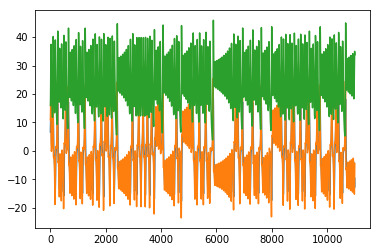

In [3]:
plt.plot(catalog.analogs)

In [4]:
#training data
batch_size = 50
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

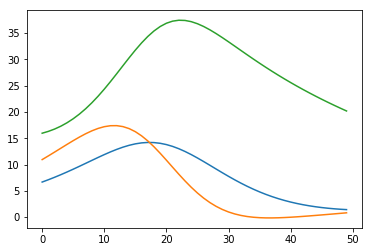

In [5]:
plt.plot(X_train[0,:,:])

In [6]:
params = {}
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_output']=3
params['dim_observations'] = 3
params['dim_hidden']=3
params['ntrain']=[1000,200]
params['dt_integration'] = GD.dt_integration
pretrained = False
path = ''# to be defined
file_name = '' # to be defined

In [7]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_input'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_input'],params['dim_input']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_input'], params['dim_input']) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            aug_inp = inp
            BP_outp = (torch.zeros((aug_inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(aug_inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](aug_inp)[:,0]*self.BlinearCell2[i](aug_inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)

In [8]:
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k1 = self.Dyn_net(inp,dt)
            inp_k2      = inp + 0.5*params['dt_integration']*k1
            k2     = self.Dyn_net(inp_k2,dt)
            inp_k3      = inp + 0.5*params['dt_integration']*k2       
            k3     = self.Dyn_net(inp_k3,dt)
            inp_k4      = inp + params['dt_integration']*k3          
            k4     = self.Dyn_net(inp_k4,dt)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1

In [9]:
dt = params['dt_integration']
aug_vect = []
x = torch.from_numpy(X_train).float()
y = torch.from_numpy(Y_train).float()
z = torch.from_numpy(Grad_t).float()

modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

if pretrained :
    modelRINN.load_state_dict(torch.load(path + file_name))


In [10]:
print ('Learning Dynamical model')        
for t in range(params['ntrain'][0]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(grad, z[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Learning Dynamical model


/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(1922.4043, grad_fn=<MseLossBackward>)
1 tensor(1404.7714, grad_fn=<MseLossBackward>)
2 tensor(1107.5684, grad_fn=<MseLossBackward>)
3 tensor(743.5679, grad_fn=<MseLossBackward>)
4 tensor(439.6688, grad_fn=<MseLossBackward>)
5 tensor(343.2701, grad_fn=<MseLossBackward>)
6 tensor(288.1611, grad_fn=<MseLossBackward>)
7 tensor(238.6879, grad_fn=<MseLossBackward>)
8 tensor(194.3240, grad_fn=<MseLossBackward>)
9 tensor(156.9684, grad_fn=<MseLossBackward>)
10 tensor(127.2649, grad_fn=<MseLossBackward>)
11 tensor(104.5640, grad_fn=<MseLossBackward>)
12 tensor(87.6762, grad_fn=<MseLossBackward>)
13 tensor(75.3743, grad_fn=<MseLossBackward>)
14 tensor(66.5822, grad_fn=<MseLossBackward>)
15 tensor(60.4052, grad_fn=<MseLossBackward>)
16 tensor(56.1186, grad_fn=<MseLossBackward>)
17 tensor(53.1480, grad_fn=<MseLossBackward>)
18 tensor(51.0309, grad_fn=<MseLossBackward>)
19 tensor(49.2662, grad_fn=<MseLossBackward>)
20 tensor(46.9680, grad_fn=<MseLossBackward>)
21 tensor(42.7987, grad_fn=<M

180 tensor(1.2428, grad_fn=<MseLossBackward>)
181 tensor(1.2729, grad_fn=<MseLossBackward>)
182 tensor(1.1460, grad_fn=<MseLossBackward>)
183 tensor(1.1416, grad_fn=<MseLossBackward>)
184 tensor(1.1331, grad_fn=<MseLossBackward>)
185 tensor(1.1192, grad_fn=<MseLossBackward>)
186 tensor(1.0868, grad_fn=<MseLossBackward>)
187 tensor(1.0456, grad_fn=<MseLossBackward>)
188 tensor(0.9942, grad_fn=<MseLossBackward>)
189 tensor(0.9381, grad_fn=<MseLossBackward>)
190 tensor(0.9050, grad_fn=<MseLossBackward>)
191 tensor(0.8832, grad_fn=<MseLossBackward>)
192 tensor(0.8622, grad_fn=<MseLossBackward>)
193 tensor(0.8429, grad_fn=<MseLossBackward>)
194 tensor(0.8252, grad_fn=<MseLossBackward>)
195 tensor(0.8090, grad_fn=<MseLossBackward>)
196 tensor(0.7943, grad_fn=<MseLossBackward>)
197 tensor(0.7808, grad_fn=<MseLossBackward>)
198 tensor(0.7683, grad_fn=<MseLossBackward>)
199 tensor(0.7567, grad_fn=<MseLossBackward>)
200 tensor(0.7457, grad_fn=<MseLossBackward>)
201 tensor(0.7351, grad_fn=<MseLos

359 tensor(0.4921, grad_fn=<MseLossBackward>)
360 tensor(0.4919, grad_fn=<MseLossBackward>)
361 tensor(0.4917, grad_fn=<MseLossBackward>)
362 tensor(0.4914, grad_fn=<MseLossBackward>)
363 tensor(0.4911, grad_fn=<MseLossBackward>)
364 tensor(0.4908, grad_fn=<MseLossBackward>)
365 tensor(0.4904, grad_fn=<MseLossBackward>)
366 tensor(0.4899, grad_fn=<MseLossBackward>)
367 tensor(0.4895, grad_fn=<MseLossBackward>)
368 tensor(0.4891, grad_fn=<MseLossBackward>)
369 tensor(0.4886, grad_fn=<MseLossBackward>)
370 tensor(0.4881, grad_fn=<MseLossBackward>)
371 tensor(0.4875, grad_fn=<MseLossBackward>)
372 tensor(0.4870, grad_fn=<MseLossBackward>)
373 tensor(0.4863, grad_fn=<MseLossBackward>)
374 tensor(0.4858, grad_fn=<MseLossBackward>)
375 tensor(0.4852, grad_fn=<MseLossBackward>)
376 tensor(0.4845, grad_fn=<MseLossBackward>)
377 tensor(0.4840, grad_fn=<MseLossBackward>)
378 tensor(0.4834, grad_fn=<MseLossBackward>)
379 tensor(0.4827, grad_fn=<MseLossBackward>)
380 tensor(0.4821, grad_fn=<MseLos

538 tensor(0.3502, grad_fn=<MseLossBackward>)
539 tensor(0.3502, grad_fn=<MseLossBackward>)
540 tensor(0.3498, grad_fn=<MseLossBackward>)
541 tensor(0.3498, grad_fn=<MseLossBackward>)
542 tensor(0.3493, grad_fn=<MseLossBackward>)
543 tensor(0.3494, grad_fn=<MseLossBackward>)
544 tensor(0.3489, grad_fn=<MseLossBackward>)
545 tensor(0.3490, grad_fn=<MseLossBackward>)
546 tensor(0.3485, grad_fn=<MseLossBackward>)
547 tensor(0.3486, grad_fn=<MseLossBackward>)
548 tensor(0.3481, grad_fn=<MseLossBackward>)
549 tensor(0.3482, grad_fn=<MseLossBackward>)
550 tensor(0.3477, grad_fn=<MseLossBackward>)
551 tensor(0.3477, grad_fn=<MseLossBackward>)
552 tensor(0.3473, grad_fn=<MseLossBackward>)
553 tensor(0.3473, grad_fn=<MseLossBackward>)
554 tensor(0.3469, grad_fn=<MseLossBackward>)
555 tensor(0.3469, grad_fn=<MseLossBackward>)
556 tensor(0.3465, grad_fn=<MseLossBackward>)
557 tensor(0.3465, grad_fn=<MseLossBackward>)
558 tensor(0.3460, grad_fn=<MseLossBackward>)
559 tensor(0.3461, grad_fn=<MseLos

717 tensor(0.3134, grad_fn=<MseLossBackward>)
718 tensor(0.3133, grad_fn=<MseLossBackward>)
719 tensor(0.3131, grad_fn=<MseLossBackward>)
720 tensor(0.3129, grad_fn=<MseLossBackward>)
721 tensor(0.3127, grad_fn=<MseLossBackward>)
722 tensor(0.3126, grad_fn=<MseLossBackward>)
723 tensor(0.3123, grad_fn=<MseLossBackward>)
724 tensor(0.3122, grad_fn=<MseLossBackward>)
725 tensor(0.3119, grad_fn=<MseLossBackward>)
726 tensor(0.3118, grad_fn=<MseLossBackward>)
727 tensor(0.3116, grad_fn=<MseLossBackward>)
728 tensor(0.3114, grad_fn=<MseLossBackward>)
729 tensor(0.3112, grad_fn=<MseLossBackward>)
730 tensor(0.3109, grad_fn=<MseLossBackward>)
731 tensor(0.3109, grad_fn=<MseLossBackward>)
732 tensor(0.3106, grad_fn=<MseLossBackward>)
733 tensor(0.3105, grad_fn=<MseLossBackward>)
734 tensor(0.3103, grad_fn=<MseLossBackward>)
735 tensor(0.3102, grad_fn=<MseLossBackward>)
736 tensor(0.3099, grad_fn=<MseLossBackward>)
737 tensor(0.3097, grad_fn=<MseLossBackward>)
738 tensor(0.3096, grad_fn=<MseLos

896 tensor(0.2853, grad_fn=<MseLossBackward>)
897 tensor(0.2852, grad_fn=<MseLossBackward>)
898 tensor(0.2851, grad_fn=<MseLossBackward>)
899 tensor(0.2849, grad_fn=<MseLossBackward>)
900 tensor(0.2848, grad_fn=<MseLossBackward>)
901 tensor(0.2847, grad_fn=<MseLossBackward>)
902 tensor(0.2846, grad_fn=<MseLossBackward>)
903 tensor(0.2844, grad_fn=<MseLossBackward>)
904 tensor(0.2843, grad_fn=<MseLossBackward>)
905 tensor(0.2842, grad_fn=<MseLossBackward>)
906 tensor(0.2840, grad_fn=<MseLossBackward>)
907 tensor(0.2839, grad_fn=<MseLossBackward>)
908 tensor(0.2838, grad_fn=<MseLossBackward>)
909 tensor(0.2837, grad_fn=<MseLossBackward>)
910 tensor(0.2836, grad_fn=<MseLossBackward>)
911 tensor(0.2835, grad_fn=<MseLossBackward>)
912 tensor(0.2833, grad_fn=<MseLossBackward>)
913 tensor(0.2832, grad_fn=<MseLossBackward>)
914 tensor(0.2831, grad_fn=<MseLossBackward>)
915 tensor(0.2831, grad_fn=<MseLossBackward>)
916 tensor(0.2829, grad_fn=<MseLossBackward>)
917 tensor(0.2827, grad_fn=<MseLos

In [11]:
print ('Optimizing flowmap')        
for t in range(params['ntrain'][1]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(pred, y[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Optimizing flowmap


/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(0.0002, grad_fn=<MseLossBackward>)
1 tensor(0.0002, grad_fn=<MseLossBackward>)
2 tensor(0.0002, grad_fn=<MseLossBackward>)
3 tensor(0.0001, grad_fn=<MseLossBackward>)
4 tensor(0.0001, grad_fn=<MseLossBackward>)
5 tensor(0.0001, grad_fn=<MseLossBackward>)
6 tensor(8.7283e-05, grad_fn=<MseLossBackward>)
7 tensor(7.2924e-05, grad_fn=<MseLossBackward>)
8 tensor(5.9821e-05, grad_fn=<MseLossBackward>)
9 tensor(4.8137e-05, grad_fn=<MseLossBackward>)
10 tensor(3.7968e-05, grad_fn=<MseLossBackward>)
11 tensor(2.9359e-05, grad_fn=<MseLossBackward>)
12 tensor(2.2295e-05, grad_fn=<MseLossBackward>)
13 tensor(1.6648e-05, grad_fn=<MseLossBackward>)
14 tensor(1.2293e-05, grad_fn=<MseLossBackward>)
15 tensor(9.0495e-06, grad_fn=<MseLossBackward>)
16 tensor(6.6890e-06, grad_fn=<MseLossBackward>)
17 tensor(5.0174e-06, grad_fn=<MseLossBackward>)
18 tensor(3.8588e-06, grad_fn=<MseLossBackward>)
19 tensor(3.0587e-06, grad_fn=<MseLossBackward>)
20 tensor(2.5006e-06, grad_fn=<MseLossBackward>)
21 te

167 tensor(1.6168e-06, grad_fn=<MseLossBackward>)
168 tensor(1.8372e-07, grad_fn=<MseLossBackward>)
169 tensor(6.2442e-06, grad_fn=<MseLossBackward>)
170 tensor(3.1358e-06, grad_fn=<MseLossBackward>)
171 tensor(8.2132e-07, grad_fn=<MseLossBackward>)
172 tensor(7.4676e-05, grad_fn=<MseLossBackward>)
173 tensor(5.0628e-08, grad_fn=<MseLossBackward>)
174 tensor(6.4705e-08, grad_fn=<MseLossBackward>)
175 tensor(1.1146e-05, grad_fn=<MseLossBackward>)
176 tensor(6.3985e-08, grad_fn=<MseLossBackward>)
177 tensor(1.7852e-06, grad_fn=<MseLossBackward>)
178 tensor(9.0722e-06, grad_fn=<MseLossBackward>)
179 tensor(1.1300e-07, grad_fn=<MseLossBackward>)
180 tensor(2.1269e-06, grad_fn=<MseLossBackward>)
181 tensor(3.2736e-05, grad_fn=<MseLossBackward>)
182 tensor(5.2748e-08, grad_fn=<MseLossBackward>)
183 tensor(4.1632e-08, grad_fn=<MseLossBackward>)
184 tensor(3.6833e-08, grad_fn=<MseLossBackward>)
185 tensor(7.7678e-08, grad_fn=<MseLossBackward>)
186 tensor(1.8945e-06, grad_fn=<MseLossBackward>)


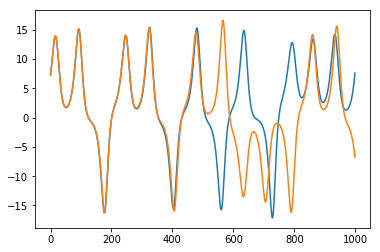

In [12]:
pred = [torch.from_numpy(xt.values[:1,:]).float()]
for i in range(1000):
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

plt.plot(torch.stack(pred).data.numpy()[:1000,0,0],label = "Prediction from LQM Dynamical model")
plt.plot(xt.values[:1000,0],label = "True state")